# Import the packages needed

In [1]:
import numpy as np
import sys,os
sys.path.append('../Code/')
import sklearn.decomposition as dp
import matplotlib.pyplot as plt
import numpy.random as rand
import numpy.linalg as la
from sPCA import spca_enc,spca_local
from matplotlib import rc
import matplotlib
matplotlib.rcParams['text.usetex'] = True

def csSim(vec1,vec2):
    vec1 = np.squeeze(vec1)
    vec2 = np.squeeze(vec2)
    num = np.dot(vec1,vec2)
    denom = la.norm(vec1)*la.norm(vec2)
    rat = num/denom
    return rat

def sortedEig(E):
    eigenValues,eigenVectors = la.eig(E)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors


## Generate the data
3 Latent dimensions with different variances to ensure identifiability with random addative noise. The train set is small to simulate a ``data-poor`` environment, but a large test set to evaluate performance

In [2]:


rand.seed(1994)
N = 100000 # Number of observations
p = 20 # Dimension of feature space
q = 1 # Supervised dimension
L = 3 # True latent dimension
eps_x = 1.5 # Noise for features
eps_y = 1.5 # Noise for supervision
S2 = rand.randn(N,L) # Latent factors

#Generating the features with set eigenvalues
lamb1 = 4.
lamb2 = 3.0
lamb3 = 2.0

S2[:,0] = S2[:,0]
S2[:,1] = S2[:,1]
S2[:,2] = S2[:,2]

W_orig = rand.randn(L,p)
W_orig[1] = W_orig[1] - np.dot(W_orig[0],W_orig[1])/np.dot(W_orig[0],W_orig[0])*W_orig[0]
W_orig[2] = W_orig[2] - np.dot(W_orig[0],W_orig[2])/np.dot(W_orig[0],W_orig[0])*W_orig[0]
W_orig[2] = W_orig[2] - np.dot(W_orig[1],W_orig[2])/np.dot(W_orig[1],W_orig[1])*W_orig[1]

W_orig[0] = W_orig[0]/la.norm(W_orig[0])*lamb1
W_orig[1] = W_orig[1]/la.norm(W_orig[1])*lamb2
W_orig[2] = W_orig[2]/la.norm(W_orig[2])*lamb3

#Supervision strength
mult = 3
D_orig = rand.randn(L,q)*mult
print(D_orig)

X_nonoise = np.dot(S2,W_orig) 
Y_nonoise = np.dot(S2,D_orig)

noise_x = eps_x*rand.randn(N,p)
noise_y = eps_y*rand.randn(N,q)

X = X_nonoise + noise_x
Y = Y_nonoise + noise_y

N = 300
X_nonoise_train = X_nonoise[:N]
Y_nonoise_train = Y_nonoise[:N]
X_train = X[:N]
Y_train = Y[:N]

X_nonoise_test = X_nonoise[N:]
Y_nonoise_test = Y_nonoise[N:]
X_test = X[N:]
Y_test = Y[N:]



[[-0.82217116]
 [ 0.98399671]
 [-0.98025875]]


## Train a sequence of local and encoded models with varying strengths and save the reconstruction and prediction costs 

In [3]:
NN = 200
mus = np.logspace(-1.5,1.5,NN)
out_x_tr_t = np.zeros(NN)
out_x_te_t = np.zeros(NN)
out_y_tr_t = np.zeros(NN)
out_y_te_t = np.zeros(NN)

out_x_tr_p = np.zeros(NN)
out_x_te_p = np.zeros(NN)
out_y_tr_p = np.zeros(NN)
out_y_te_p = np.zeros(NN)

drag_s = np.zeros(NN)

for i in range(NN):
    model = spca_local(3,lamb=mus[i])
    model.fit(X_train,Y_train)

    S_train_p = model.project(X_train)
    S_test_p = model.project(X_test)
    S_train = model.transform(X_train,Y_train)
    S_test = model.transform(X_test,Y_test)
    Wx = model.W_
    Wy = model.D_


    X_recon_train = np.dot(S_train_p,Wx.T)
    X_recon_test = np.dot(S_test_p,Wx.T)
    Y_recon_train = np.dot(S_train_p,Wy.T)
    Y_recon_test = np.dot(S_test_p,Wy.T)

    #These have y known
    X_recon_train_t = np.dot(S_train,Wx.T)
    X_recon_test_t = np.dot(S_test,Wx.T)
    Y_recon_train_t = np.dot(S_train,Wy.T)
    Y_recon_test_t = np.dot(S_test,Wy.T)


    out_x_tr_p[i] = np.mean((X_recon_train-X_train)**2)
    out_x_te_p[i] = np.mean((X_recon_test-X_test)**2)
    out_y_tr_p[i] = np.mean((Y_recon_train-Y_train)**2)
    out_y_te_p[i] = np.mean((Y_recon_test-Y_test)**2)

    #These have y known _t
    out_x_tr_t[i] = np.mean((X_recon_train_t-X_train)**2)
    out_x_te_t[i] = np.mean((X_recon_test_t-X_test)**2)
    out_y_tr_t[i] = np.mean((Y_recon_train_t-Y_train)**2)
    out_y_te_t[i] = np.mean((Y_recon_test_t-Y_test)**2)

    drag_s[i] = np.mean((S_test-S_test_p)**2)
    
out_x_tr_p_e = np.zeros(NN)
out_x_te_p_e = np.zeros(NN)
out_y_tr_p_e = np.zeros(NN)
out_y_te_p_e = np.zeros(NN)

for i in range(NN):
    model = spca_enc(3,lamb=mus[i])
    model.fit(X_train,Y_train)

    S_train_p = model.project(X_train)
    S_test_p = model.project(X_test)
    Wx = model.W_
    Wy = model.D_


    X_recon_train = np.dot(S_train_p,Wx.T)
    X_recon_test = np.dot(S_test_p,Wx.T)
    Y_recon_train = np.dot(S_train_p,Wy.T)
    Y_recon_test = np.dot(S_test_p,Wy.T)

    out_x_tr_p_e[i] = np.mean((X_recon_train-X_train)**2)
    out_x_te_p_e[i] = np.mean((X_recon_test-X_test)**2)
    out_y_tr_p_e[i] = np.mean((Y_recon_train-Y_train)**2)
    out_y_te_p_e[i] = np.mean((Y_recon_test-Y_test)**2)

## Generate the plots

Text(0.5, 1.0, 'Local Factor Dragging')

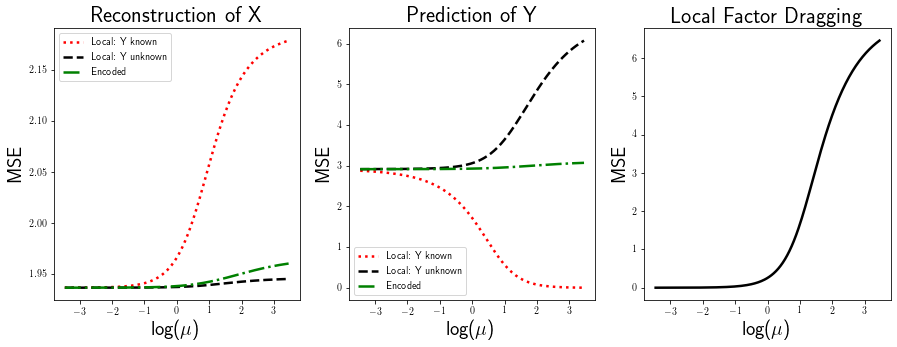

In [4]:
fs1 = 20
fs2 = 22
lw = 2.5
lMus = np.log(mus)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3);
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(lMus,out_x_te_t,c='r',linestyle='dotted',lw=lw,label='Local: Y known')
ax1.plot(lMus,out_x_te_p,c='k',linestyle='dashed',lw=lw,label='Local: Y unknown')
ax1.plot(lMus,out_x_te_p_e,c='g',linestyle='dashdot',lw=lw,label='Encoded')
ax1.set_xlabel('log($\mu$)',fontsize=fs1)
ax1.set_ylabel('MSE',fontsize=fs1)
ax1.legend(loc='upper left')
ax1.set_title('Reconstruction of X',fontsize=fs2)

ax2.plot(lMus,out_y_te_t,c='r',linestyle='dotted',lw=lw,label='Local: Y known')
ax2.plot(lMus,out_y_te_p,c='k',linestyle='dashed',lw=lw,label='Local: Y unknown')
ax2.plot(lMus,out_y_te_p_e,c='g',linestyle='dashdot',lw=lw,label='Encoded')
ax2.set_xlabel('log($\mu$)',fontsize=fs1)
ax2.set_ylabel('MSE',fontsize=fs1)
ax2.legend(loc='lower left')
ax2.set_title('Prediction of Y',fontsize=fs2)

ax3.plot(lMus,drag_s,lw=lw,c='k')
ax3.set_xlabel('log($\mu$)',fontsize=fs1)
ax3.set_ylabel('MSE',fontsize=fs1)
ax3.set_title('Local Factor Dragging',fontsize=fs2)
#fig.savefig('Example1.pdf')